### UCI Drug review analysis

kaggle url: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018

In [88]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from datasets import load_dataset, load_metric

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler

# training
import torch
from torch.utils.data import DataLoader

# preprocessing & metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report

# progress bar
from tqdm import tqdm

# cash cleaning
import gc

In [118]:
df_train = pd.read_csv('drugsComTrain_raw.csv',parse_dates=['date'])
df_test = pd.read_csv('drugsComTest_raw.csv',parse_dates=['date'])

In [13]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79


In [14]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79


Text(0.5, 1.0, 'Relation of rating to usefulCount')

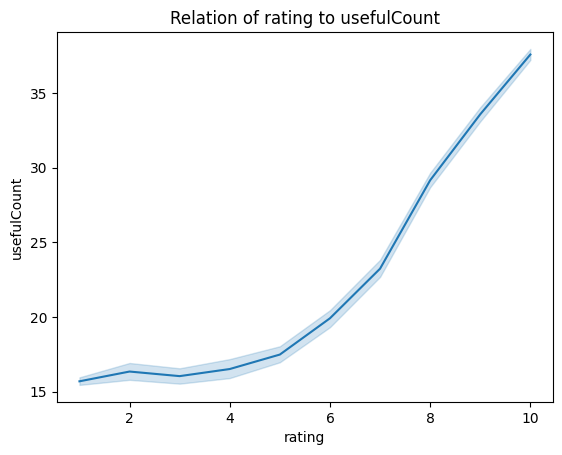

In [332]:
sns.lineplot(x='rating',y='usefulCount',data=df_train)
plt.title('Relation of rating to usefulCount')

Text(0.5, 1.0, 'Number of reviews by years')

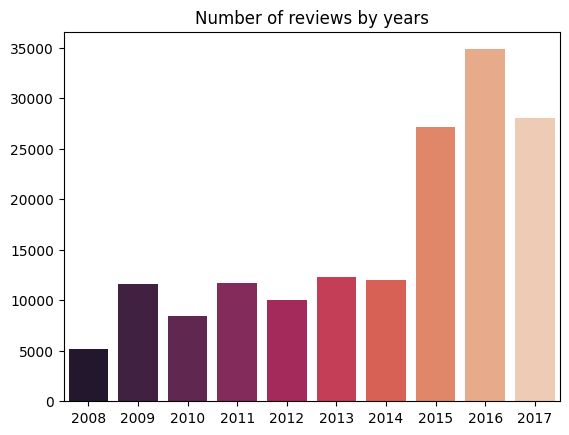

In [333]:
cnt = df_train['date'].dt.year.value_counts().sort_index()
sns.barplot(x=cnt.index, y=cnt.values, palette="rocket")
plt.title('Number of reviews by years')

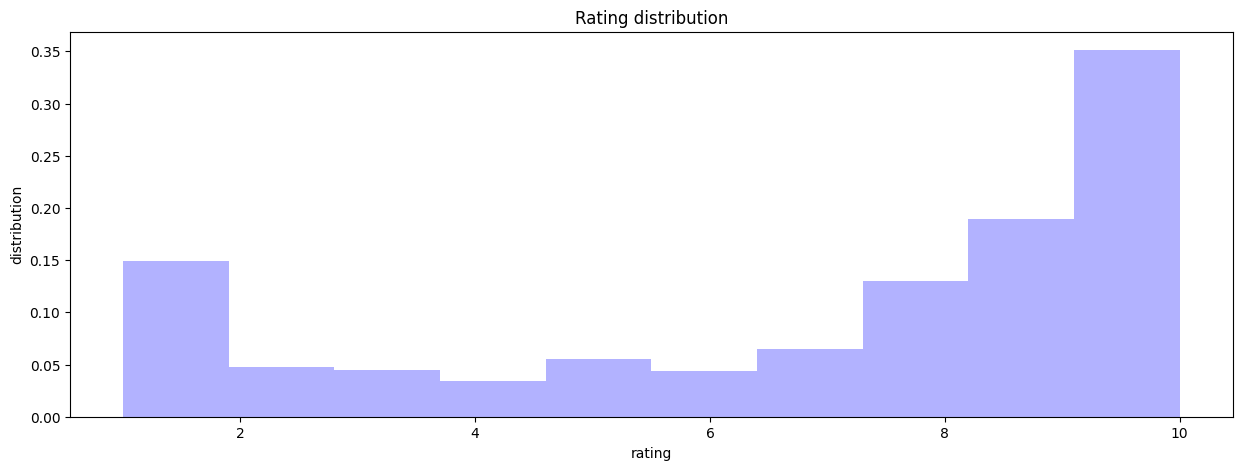

In [17]:
plt.figure(figsize=(15,5))
plt.hist(df_train['rating'],density=True,bins=10,color=['blue'],alpha=0.3)

plt.title('Rating distribution')
plt.xlabel('rating')
plt.ylabel('distribution')
plt.show()

In [18]:
# sns.displot(df_train['rating'],height=5,aspect=2.5)
# plt.ylabel('number')
# plt.show()

<AxesSubplot: title={'center': 'Top 20 drugs'}>

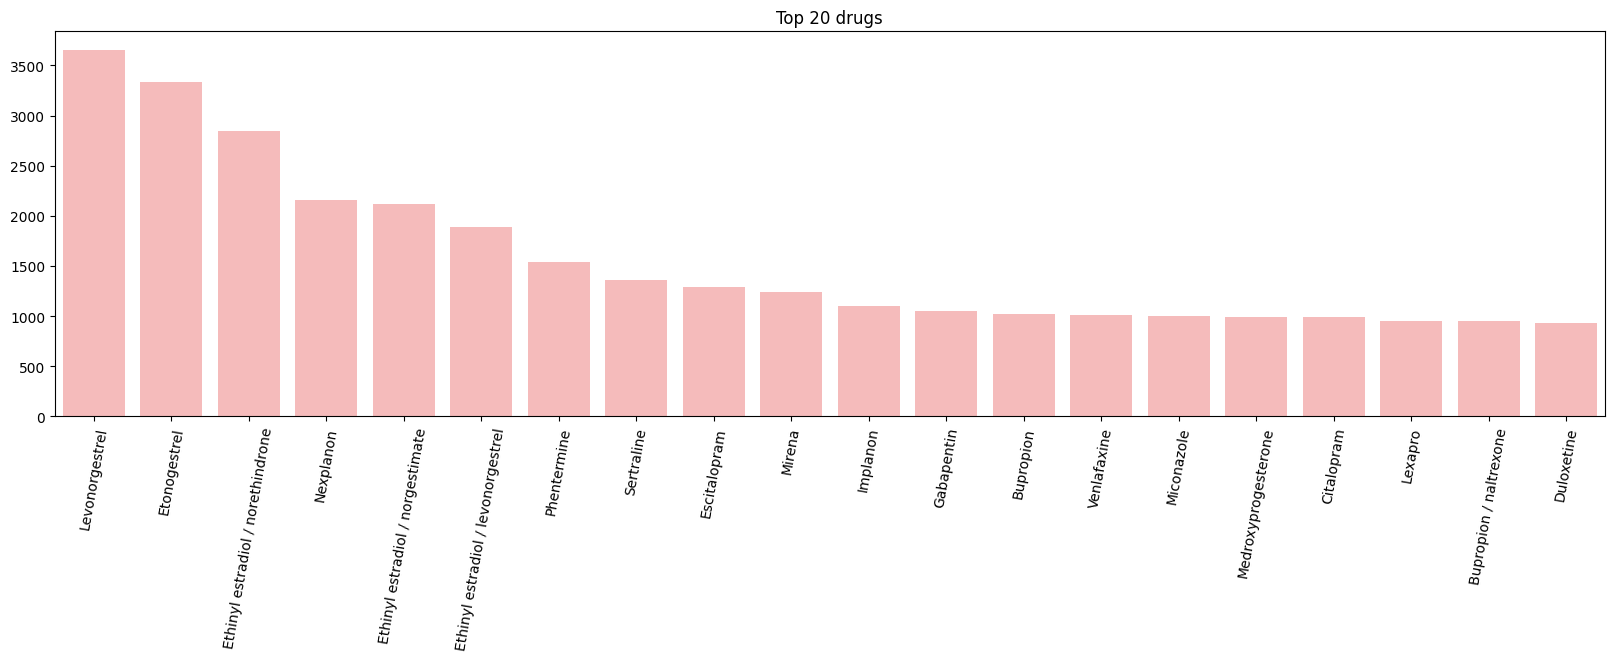

In [19]:
drug = df_train['drugName']

drug = drug.value_counts()

plt.figure(figsize=(20,5))

plt.title('Top 20 drugs')
plt.xticks(rotation=80)
sns.barplot(x=drug.index[:20],y=drug.values[:20],color='red',alpha=0.3)



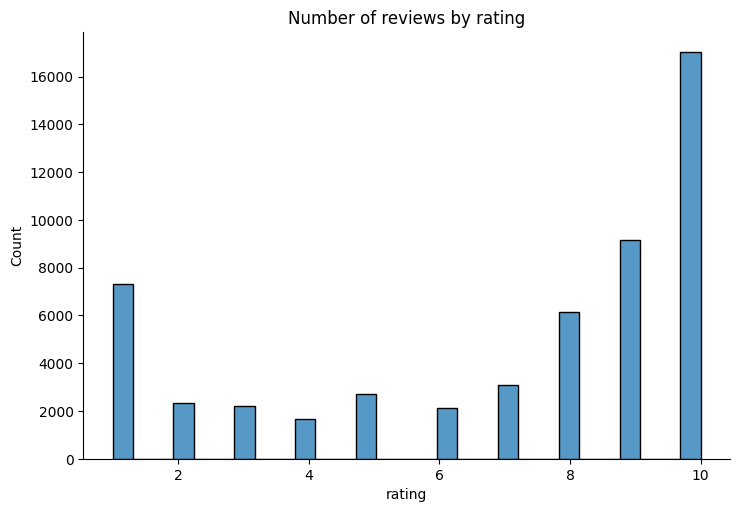

In [334]:
# plt.figure(figsize=(9,9))
# fig, ax = plt.subplots(figsize=(15,9))
# sns.set(rc={'figure.figsize':(7,7)})

# sns.displot(df_train['rating'],kind='hist',height=5,aspect=1.5)
# sns.displot(df_train['rating'],kind='kde')
sns.displot(df_test['rating'],kind='hist',height=5,aspect=1.5)
plt.title('Number of reviews by rating')


plt.show()

model and tokenizer

In [21]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Loading model from pretrained localy

In [161]:
model = DistilBertForSequenceClassification.from_pretrained('./best_model_dec_2022_f1_max=0.48743694537309445_len=100')

In [66]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [23]:
model.classifier

Linear(in_features=768, out_features=10, bias=True)

In [17]:
df_train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [105]:
print(df_train['review'][0])
print(df_train['rating'][0])

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
8


Text preprocessing

In [67]:
import re

In [114]:
# df_train['review_edited'] = df_train['review'].apply(lambda x: x.replace('"',''))
# df_test['review_edited'] = df_test['review'].apply(lambda x: x.replace('"',''))

In [87]:
#cleaning text with re
def cleantext(text):
    # ct = text.lower()
    cleanr = re.compile('<.*?>')
    ct = re.sub(cleanr, ' ', text)
    ct = re.sub(r'[?|!|\'|"|#]',r'',ct)
    ct = re.sub(r'[.|,|)|(|\|/]',r'',ct) 
    ct = re.sub('[^A-Za-z0-9]+', ' ', ct)
    return ct

In [121]:
df_train['review_edited'] = df_train['review'].apply(lambda x: cleantext(x))
df_test['review_edited'] = df_test['review'].apply(lambda x: cleantext(x))

In [90]:
#Since for training we need our classes be from 0 to 9 we subtract 1 from original clases
df_train['rating'] = df_train['rating'].apply(lambda x: x-1)
df_test['rating'] = df_test['rating'].apply(lambda x: x-1)

In [93]:
df_test['rating'].value_counts()

9    17016
8     9177
0     7299
7     6156
6     3091
4     2710
1     2334
2     2205
5     2119
3     1659
Name: rating, dtype: int64

In [122]:
df_train['review_edited']

0         It has no side effect I take it in combination...
1         My son is halfway through his fourth week of I...
2         I used to take another oral contraceptive whic...
3         This is my first time using any form of birth ...
4         Suboxone has completely turned my life around ...
                                ...                        
161292    I wrote my first report in Mid October of 2014...
161293    I was given this in IV before surgey I immedia...
161294    Limited improvement after 4 months developed b...
161295    I 039 ve been on thyroid medication 49 years I...
161296    I 039 ve had chronic constipation all my adult...
Name: review_edited, Length: 161297, dtype: object

In [162]:
# train = df_train[['tokenized_review_edited','rating']]
train = df_train[['review_edited','rating']]
test = df_test[['review_edited', 'rating']]

In [23]:
# train.columns = ['sentence','label']

In [24]:
# len(df_train['tokenized_review_edited'][3])

In [163]:
train

,review_edited,rating
0,It has no side effect I take it in combination...,9
1,My son is halfway through his fourth week of I...,8
2,I used to take another oral contraceptive whic...,5
3,This is my first time using any form of birth ...,8
4,Suboxone has completely turned my life around ...,9
...,...,...
161292,I wrote my first report in Mid October of 2014...,10
161293,I was given this in IV before surgey I immedia...,1
161294,Limited improvement after 4 months developed b...,2
161295,I 039 ve been on thyroid medication 49 years I...,10


In [164]:
test

,review_edited,rating
0,I 039 ve tried a few antidepressants over the ...,10
1,My son has Crohn 039 s disease and has done ve...,8
2,Quick reduction of symptoms,9
3,Contrave combines drugs that were used for alc...,9
4,I have been on this birth control for one cycl...,9
...,...,...
53761,I have taken Tamoxifen for 5 years Side effect...,10
53762,I 039 ve been taking Lexapro escitaploprgram s...,9
53763,I 039 m married 34 years old and I have no kid...,8
53764,I was prescribed Nucynta for severe neckshould...,1


In [169]:
# cutting long descriptions
train['review_edited'] = train['review_edited'].apply(lambda x: ' '.join(x.split()[:100]) if len(x.split())>100 else x)

C:\Users\beori\AppData\Local\Temp\ipykernel_6208\3328795260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['review_edited'] = train['review_edited'].apply(lambda x: ' '.join(x.split()[:100]) if len(x.split())>100 else x)


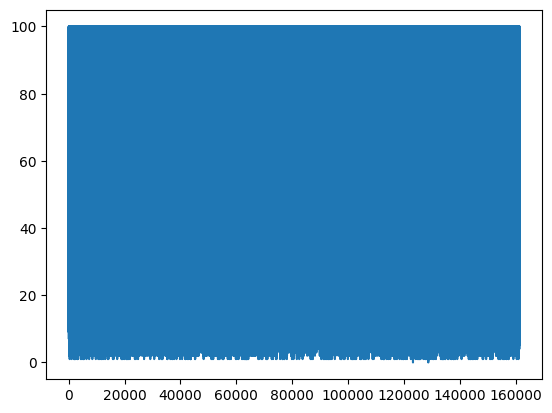

In [170]:
max_len_list = []
for i in train['review_edited']:
    max_len_list.append(len(i.split()))

plt.plot(max_len_list)

In [210]:
import random

train['review_edited'][random.randint(0,160000)]

'Amitiza has worked well for over two years to control constipation which is a direct result of opioids taken for pain control However my doctor gave me a box of Movantik to try instead NEVER AGAIN Within a short period of time my colon began cramping for several hours Initially I hoped that a bowel movement would reduce the pain It did not I then got diarrhea Not wanting to call 911 I tried to breath deeply as I went from chills to sweats to chills amp the cramping continuedPraying not to throw up but when I did it was'

In [202]:
import random

test['review_edited'][random.randint(0,len(test['review_edited']))]

'I 039 ve been using the generic Eflora which has the same active ingredient I have dark coarse on parts of my face My upper lip isn 039 t too bad manageable mostly just dark fine hairs but my chin is horrible If I shaved it really had to be twice a day and even after shaving my skin could still feel prickly The left side was inexplicably worse than the right I started noticing results on the thinner andor slower growing hair first Two Weeks Start seeing results with hair between eyebrows and on upper lip these areas weren 039 t too bad Four Weeks Start seeing results all over including chin Eight Weeks Still improving growth extremely slowed except for left side of chin Left side of chin is slowing just not as much'

In [211]:
# change name of columns for huggin face standart
train.columns = ['description', 'labels']
test.columns = ['description', 'labels']

In [137]:
test

,description,labels
0,"""I&#';ve tried a few antidepressants over the ...",9
1,"""My son has Crohn&#';s disease and has done ve...",7
2,"""Quick reduction of symptoms""",8
3,"""Contrave combines drugs that were used for al...",8
4,"""I have been on this birth control for one cyc...",8
...,...,...
53761,"""I have taken Tamoxifen for 5 years. Side effe...",9
53762,"""I&#';ve been taking Lexapro (escitaploprgram)...",8
53763,"""I&#';m married, 34 years old and I have no ki...",7
53764,"""I was prescribed Nucynta for severe neck/shou...",0


In [212]:
len(train), len(test)

(161297, 53766)

In [213]:
# check if # of classes of df == # classes of train
print(len(train['labels'].value_counts()))

10


In [214]:
# check if # of classes of df == # classes of test
print(len(test['labels'].value_counts()))

10


In [215]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [132]:
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [216]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
model.to(device)
device

device(type='cuda')

dataset

In [4]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Using custom data configuration default-d87a53bd56eb7f0e
Found cached dataset csv (C:/Users/beori/.cache/huggingface/datasets/csv/default-d87a53bd56eb7f0e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
dataset['train']['description'][0]

'It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil'

Tokenizing dataset

In [136]:
dataset = dataset.map(lambda e: tokenizer(e['description'], truncation = True, max_length=100, padding='max_length'), batched=True)

  0%|          | 0/162 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

Saving encoded dataset

In [139]:
dataset.save_to_disk('dataset_cleaned')

Loading encoded dataset

In [ ]:
from datasets import load_from_disk
dataset = load_from_disk("dataset_cleaned")

In [140]:
# this is standart columns for pytorch
# pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  # 
# however distillbert doesn't have token_type_ids so i got rid of it
pytorch_style_columns = ['input_ids',  'attention_mask', 'labels']
# убираем их из загрузчика
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns))) 

In [56]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 53766
    })
})

In [141]:
# translate to pytorch format
# loading to cuda

dataset.set_format(type='torch', columns=['labels', 'input_ids', 'attention_mask'], device='cuda') 

In [142]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 53766
    })
})

In [143]:
dataset['train'].__getitem__(0)

{'labels': tensor(8, device='cuda:0'),
 'input_ids': tensor([  101,  1000,  2009,  2038,  2053,  2217,  3466,  1010,  1045,  2202,
          2009,  1999,  5257,  1997,  2011, 16033, 10415,  1019, 11460,  1998,
          3869,  3514,  1000,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        device='cuda:0'),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0,

In [157]:

train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=512,)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=512,)

In [145]:
len(train_dataloader)

316

In [146]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 53766
    })
})

Optimizer

In [147]:
# оптимизатор AdamW, лр стоит поперебирать
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# количество эпох можно побольше поставить
num_epochs = 4
# количество шагов
num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [158]:
torch.cuda.empty_cache()

In [159]:
import gc
gc.collect()

1731

Train

In [154]:
device

device(type='cuda')

In [160]:
# лучший f1, по нему будем сохранять
best_f1 = 0.
# будем отображать каждые 10% эпохи
show_train_loss_every_num_epoch = 0.1

# проходимся по всем эпохам
for epoch in tqdm(range(num_epochs)):
    # отображаем номера эпох
    print(40*'-', '\nepoch', epoch+1)
    # переводим в режим тренировки
    model.train()
    # смотрим на средний лосс за 10% эпохи
    losses = []
    # итерируемся по треин части 
    for i, batch in enumerate(train_dataloader):
        
        # переводим в режим тренировки
        model.train()
        # print(batch)
        # переносим батч на гпу, где и модель
        batch = {k: v.to(device) for k, v in batch.items()}
        # print(batch)
        # получаем прогнозы
        outputs = model(**batch)
        # print(outputs)
        # получаем лосс встроенный вместе с моделью (кросс-энтропия)
        loss = outputs.loss
        # print(loss)
        # делаем обратный проход
        loss.backward()
        # шаг по градиенту
        optimizer.step()
        # шаг по скорости
        lr_scheduler.step()
        # шаг по оптимизатору
        optimizer.zero_grad()
        # фиксируем потери на треин
        losses.append(loss.item())
        # отображаем каждый 10% эпохи
        if i%int(len(train_dataloader)*show_train_loss_every_num_epoch)==int(len(train_dataloader)*show_train_loss_every_num_epoch)-1:
            print(f'train loss [{i*100/len(train_dataloader):.2f}%]: {np.array(losses).mean():.3f}')
            losses = []
            # валидируемся в конце эпохи
            print('\nvalidating')
            # загружаем все основные метрики
            f1 = load_metric('f1')
            acc = load_metric('accuracy')
            precision = load_metric('precision')
            recall = load_metric('recall')
            with torch.no_grad():
                # переводим в режим валидации
                model.eval()
                # проходимся по всем батчам из теста
                for batch in tqdm(test_dataloader):
                    # переносим их на гпу
                    batch = {k: v.to(device) for k, v in batch.items()}
                    # не обновляя параметры получаем прогнозы
                    with torch.no_grad():
                        outputs = model(**batch)
                    # получаем сразу логиты
                    logits = outputs.logits
                    # находим верный ответ
                    predictions = torch.argmax(logits, dim=-1)
                    # логируем в метрики по f1
                    f1.add_batch(predictions=predictions, references=batch["labels"])    
                    acc.add_batch(predictions=predictions, references=batch["labels"])    
                    precision.add_batch(predictions=predictions, references=batch["labels"])    
                    recall.add_batch(predictions=predictions, references=batch["labels"])    
                # находим взвешенные по кол-ву примеров на тест метрики
                print('weighted summary:')
                print('Test acc:', acc.compute()['accuracy'])
                print('Test precision:', precision.compute(average = 'weighted')['precision'])
                print('Test recall:', recall.compute(average = 'weighted')['recall'])
                f1_weighted = f1.compute(average = 'weighted')['f1']
                print('Test f1:', f1_weighted, '\n')
                # если текущая f1 лучше максимальной
                if f1_weighted > best_f1:
                    # максмальная становится текущей
                    best_f1 = f1_weighted
                    # сохраняем модель
                    model.save_pretrained(f"best_model_dec_2022_f1_max={best_f1}_len=100")

    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

  0%|          | 0/4 [00:00<?, ?it/s]

---------------------------------------- 
epoch 1
train loss [9.49%]: 1.291

validating


100%|██████████| 106/106 [01:03<00:00,  1.67it/s]


weighted summary:
Test acc: 0.48093590745080533
Test precision: 0.4300407293142883
Test recall: 0.48093590745080533
Test f1: 0.43808632906844197 

train loss [19.30%]: 1.300

validating


100%|██████████| 106/106 [01:08<00:00,  1.55it/s]


weighted summary:
Test acc: 0.48153107912063386
Test precision: 0.4344787032318817
Test recall: 0.48153107912063386
Test f1: 0.44268115171768885 

train loss [29.11%]: 1.290

validating


100%|██████████| 106/106 [01:01<00:00,  1.72it/s]


weighted summary:
Test acc: 0.4816612729234088
Test precision: 0.4379375691857198
Test recall: 0.4816612729234088
Test f1: 0.4447358157366031 

train loss [38.92%]: 1.268

validating


100%|██████████| 106/106 [01:05<00:00,  1.61it/s]


weighted summary:
Test acc: 0.48234944016664805
Test precision: 0.44070113399454547
Test recall: 0.48234944016664805
Test f1: 0.4477576454917902 

train loss [48.73%]: 1.267

validating


100%|██████████| 106/106 [01:07<00:00,  1.57it/s]


weighted summary:
Test acc: 0.48461853215786926
Test precision: 0.4367439714205926
Test recall: 0.48461853215786926
Test f1: 0.44678966764046585 

train loss [58.54%]: 1.266

validating


100%|██████████| 106/106 [01:15<00:00,  1.41it/s]


weighted summary:
Test acc: 0.48556708700665846
Test precision: 0.43838318524749315
Test recall: 0.48556708700665846
Test f1: 0.44739525320791257 

train loss [68.35%]: 1.257

validating


100%|██████████| 106/106 [01:03<00:00,  1.68it/s]


weighted summary:
Test acc: 0.4850649109102407
Test precision: 0.4496485790101749
Test recall: 0.4850649109102407
Test f1: 0.4532654550905222 

train loss [78.16%]: 1.253

validating


100%|██████████| 106/106 [01:05<00:00,  1.62it/s]


weighted summary:
Test acc: 0.4874083993601905
Test precision: 0.4409495411390059
Test recall: 0.4874083993601905
Test f1: 0.44815880102408934 

train loss [87.97%]: 1.261

validating


100%|██████████| 106/106 [01:02<00:00,  1.71it/s]


weighted summary:
Test acc: 0.48831975597961536
Test precision: 0.44777802693312513
Test recall: 0.48831975597961536
Test f1: 0.45655736818279896 

train loss [97.78%]: 1.253

validating


100%|██████████| 106/106 [01:02<00:00,  1.69it/s]


weighted summary:
Test acc: 0.4902354647918759
Test precision: 0.44782797600441016
Test recall: 0.4902354647918759
Test f1: 0.45460928892623337 



 25%|██▌       | 1/4 [18:47<56:23, 1127.95s/it]

---------------------------------------- 
epoch 2
train loss [9.49%]: 1.243

validating


100%|██████████| 106/106 [01:01<00:00,  1.73it/s]


weighted summary:
Test acc: 0.4885987426998475
Test precision: 0.45015976874023034
Test recall: 0.4885987426998475
Test f1: 0.45891793746786197 

train loss [19.30%]: 1.214

validating


100%|██████████| 106/106 [00:56<00:00,  1.87it/s]


weighted summary:
Test acc: 0.4907190417736116
Test precision: 0.45387851849344096
Test recall: 0.4907190417736116
Test f1: 0.459502248147559 

train loss [29.11%]: 1.235

validating


100%|██████████| 106/106 [01:09<00:00,  1.52it/s]


weighted summary:
Test acc: 0.4941598779898077
Test precision: 0.4443187356319709
Test recall: 0.4941598779898077
Test f1: 0.4547451206141312 

train loss [38.92%]: 1.235

validating


100%|██████████| 106/106 [01:02<00:00,  1.71it/s]


weighted summary:
Test acc: 0.4937134992374363
Test precision: 0.45658408697752684
Test recall: 0.4937134992374363
Test f1: 0.4614512149314442 

train loss [48.73%]: 1.227

validating


100%|██████████| 106/106 [00:59<00:00,  1.77it/s]


weighted summary:
Test acc: 0.49546181601755757
Test precision: 0.44654878154025557
Test recall: 0.49546181601755757
Test f1: 0.45416232946976864 

train loss [58.54%]: 1.230

validating


100%|██████████| 106/106 [00:45<00:00,  2.33it/s]


weighted summary:
Test acc: 0.49468065320090765
Test precision: 0.4350240108639007
Test recall: 0.49468065320090765
Test f1: 0.44746349738456254 

train loss [68.35%]: 1.229

validating


100%|██████████| 106/106 [00:51<00:00,  2.07it/s]


weighted summary:
Test acc: 0.5004835769817356
Test precision: 0.4509580712217948
Test recall: 0.5004835769817356
Test f1: 0.45592904333600554 

train loss [78.16%]: 1.241

validating


100%|██████████| 106/106 [00:50<00:00,  2.08it/s]


weighted summary:
Test acc: 0.4992932336420786
Test precision: 0.46004798250445234
Test recall: 0.4992932336420786
Test f1: 0.4671970895285042 

train loss [87.97%]: 1.221

validating


100%|██████████| 106/106 [00:51<00:00,  2.08it/s]


weighted summary:
Test acc: 0.49326712048506494
Test precision: 0.47113920415827193
Test recall: 0.49326712048506494
Test f1: 0.47454596384634845 

train loss [97.78%]: 1.219

validating


100%|██████████| 106/106 [00:50<00:00,  2.09it/s]


weighted summary:
Test acc: 0.5038128185098389
Test precision: 0.46335231450362285
Test recall: 0.5038128185098389
Test f1: 0.466264322376663 



 50%|█████     | 2/4 [34:52<34:24, 1032.01s/it]

---------------------------------------- 
epoch 3
train loss [9.49%]: 1.165

validating


100%|██████████| 106/106 [00:50<00:00,  2.11it/s]


weighted summary:
Test acc: 0.5015437265186177
Test precision: 0.45405460108258033
Test recall: 0.5015437265186177
Test f1: 0.4557485248746024 

train loss [19.30%]: 1.171

validating


100%|██████████| 106/106 [00:49<00:00,  2.14it/s]


weighted summary:
Test acc: 0.5050403600788602
Test precision: 0.4550094453896538
Test recall: 0.5050403600788602
Test f1: 0.4593805632628194 

train loss [29.11%]: 1.173

validating


100%|██████████| 106/106 [00:49<00:00,  2.15it/s]


weighted summary:
Test acc: 0.496447569095711
Test precision: 0.4750245201234419
Test recall: 0.496447569095711
Test f1: 0.4770641682092902 

train loss [38.92%]: 1.161

validating


100%|██████████| 106/106 [00:51<00:00,  2.06it/s]


weighted summary:
Test acc: 0.5061005096157423
Test precision: 0.4524667231905447
Test recall: 0.5061005096157423
Test f1: 0.46026572260803317 

train loss [48.73%]: 1.159

validating


100%|██████████| 106/106 [00:50<00:00,  2.10it/s]


weighted summary:
Test acc: 0.5105270989100918
Test precision: 0.46000802189824636
Test recall: 0.5105270989100918
Test f1: 0.469060441113597 

train loss [58.54%]: 1.165

validating


100%|██████████| 106/106 [00:50<00:00,  2.10it/s]


weighted summary:
Test acc: 0.5119778298552989
Test precision: 0.4644822782674393
Test recall: 0.5119778298552989
Test f1: 0.47281012298628255 

train loss [68.35%]: 1.163

validating


100%|██████████| 106/106 [00:51<00:00,  2.06it/s]


weighted summary:
Test acc: 0.513577353717963
Test precision: 0.47823161153922195
Test recall: 0.513577353717963
Test f1: 0.48743694537309445 



 50%|█████     | 2/4 [45:05<45:05, 1352.62s/it]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000247D33F2950>
Traceback (most recent call last):
  File "C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\multiprocessing\popen_spawn

KeyboardInterrupt: 

In [231]:
t

{'input_ids': tensor([[  101,  2009,  2001,  1037,  2204, 14667,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Classifying single sentence

In [327]:
sentence = '''This drug is part of the comprehensive treatment and restoration of the heart after a heart attack. I get the drug for free while I am on disability. Due to the fact that I have been taking this drug for the 3rd year, I can say with confidence that taking it in combination with other medications keeps my well-being at a stable level.
'''

Predicted rating = 9


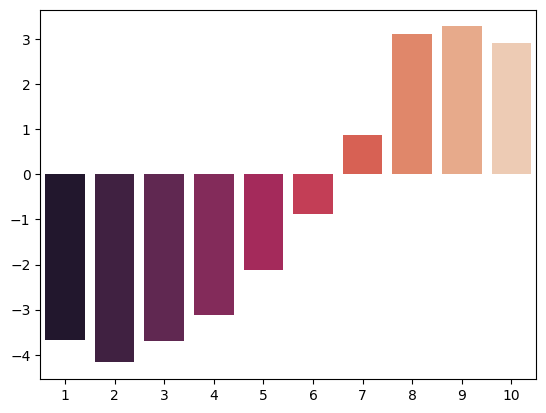

In [328]:
t = tokenizer(sentence, truncation = True, max_length=100, padding='max_length',return_tensors='pt').to(device)

model.eval()
outputs = model.forward(**t)
# print(outputs)

logits = outputs.logits
# print(logits)
sns.barplot(x=list(range(1,11)), y=np.squeeze(logits.to('cpu').detach().numpy()), palette="rocket")

predictions = torch.argmax(logits, dim=-1)
print('Predicted rating =',np.squeeze((predictions+1).to('cpu').detach().numpy()))



Summary

- We have pretty big base of reviews, although it is imbalanced in respect to rating.
Thats why i decided to use f1-weightned as a primary metric for evaluation
- Net succesfully trained and loss get lower. Finally i stopped training by myself, in spite of loss being slowly decreasing. 
But i dont think that f1-weightned around 0.5 is a good metric, although if i convert 10 classes into 5 ,for example, i'm sure it increase metrics.
- Also i suspect that text may be preprocessed better and i can choose another model for sequence classification.

- As this model is already distilled it is faster than origin Bert, and unfortunately i fell short in time to make a distillation to lsmt :(